Q1. Using the URDF file, determine the screw axes (Si ∈ R 6 or Bi ∈ R 6) of the robot joints when the robot is at its home/zero configuration. Note that a fixed space frame {s} is attached to the robot base, and a body frame {b} is attached to the robot end-effector. To have a better understanding of the pose of the robot axes at its home/zero configuration, import the URDF file into Python using the function load urdf in pytransform3d package (Fig. 1). For more details, refer to the sample code in the folder assigned to your group.

In [92]:
import numpy as np
from scipy.spatial.transform import Rotation

joints_data = [
    {
        'name': 'joint1',
        'parent': 'link_base',
        'child': 'link1',
        'origin': [0, 0, 0.267],
        'rpy': [0, 0, 0],
        'axis': [0, 0, 1]  
    },
    {
        'name': 'joint2',
        'parent': 'link1',
        'child': 'link2',
        'origin': [0, 0, 0],
        'rpy': [-1.5708, 0, 0],  
        'axis': [0, 0, 1]
    },
    {
        'name': 'joint3',
        'parent': 'link2',
        'child': 'link3',
        'origin': [0, -0.293, 0],
        'rpy': [1.5708, 0, 0],
        'axis': [0, 0, 1]
    },
    {
        'name': 'joint4',
        'parent': 'link3',
        'child': 'link4',
        'origin': [0.0525, 0, 0],
        'rpy': [1.5708, 0, 0], 
        'axis': [0, 0, 1]
    },
    {
        'name': 'joint5',
        'parent': 'link4',
        'child': 'link5',
        'origin': [0.0775, -0.3425, 0],
        'rpy': [1.5708, 0, 0], 
        'axis': [0, 0, 1]
    },
    {
        'name': 'joint6',
        'parent': 'link5',
        'child': 'link6',
        'origin': [0, 0, 0],
        'rpy': [1.5708, 0, 0],  
        'axis': [0, 0, 1]
    },
    {
        'name': 'joint7',
        'parent': 'link6',
        'child': 'link7',
        'origin': [0.076, 0.097, 0],
        'rpy': [-1.5708, 0, 0],  
        'axis': [0, 0, 1]
    }
]

def rpy_to_rotation_matrix(rpy):
    r = Rotation.from_euler('xyz', rpy)
    return r.as_matrix()

def transformation_matrix(origin, rpy):
    T = np.eye(4)
    T[:3, :3] = rpy_to_rotation_matrix(rpy)
    T[:3, 3] = origin
    return T

def skew_symmetric(v):
    return np.array([
        [0, -v[2], v[1]],
        [v[2], 0, -v[0]],
        [-v[1], v[0], 0]
    ])

def compute_screw_axis(omega, q):
    
    omega = np.array(omega)
    q = np.array(q)
    v = -np.cross(omega, q)
    return np.concatenate([v, omega])

def adjoint_transformation(T):
    R = T[:3, :3]
    p = T[:3, 3]
    Ad = np.zeros((6, 6))
    Ad[:3, :3] = R
    Ad[3:, 3:] = R
    Ad[:3, 3:] = skew_symmetric(p) @ R
    return Ad

# ============================================================================
# FORWARD KINEMATICS - COMPUTE JOINT FRAMES IN SPACE FRAME
# ============================================================================

T_current = np.eye(4)  
joint_transforms = []  

for i, joint in enumerate(joints_data):
    T_joint = transformation_matrix(joint['origin'], joint['rpy'])
    
    T_current = T_current @ T_joint
    joint_transforms.append(T_current.copy())


M = T_current.copy()

# ============================================================================
# SPACE FRAME SCREW AXES (Si)
# ============================================================================

space_screws = []

for i, (joint, T) in enumerate(zip(joints_data, joint_transforms)):
    # Local axis in joint frame
    axis_local = np.array(joint['axis'])
    
    # Transform axis to space frame using rotation part of T
    R = T[:3, :3]
    omega_s = R @ axis_local
    omega_s = omega_s / np.linalg.norm(omega_s) 
    
    # Position of joint origin in space frame
    q_s = T[:3, 3]
    
    # Compute screw axis
    S_i = compute_screw_axis(omega_s, q_s)
    space_screws.append(S_i)



# ============================================================================
# BODY FRAME SCREW AXES (Bi)
# ============================================================================

M_inv = np.linalg.inv(M)
Ad_M_inv = adjoint_transformation(M_inv)

body_screws = []

for i, S_i in enumerate(space_screws):
    B_i = Ad_M_inv @ S_i
    body_screws.append(B_i)

print("\nSPACE FRAME SCREW AXES (Si):")
for i, S in enumerate(space_screws):
    print(f"   S{i+1} = {S}")

print("\nBODY FRAME SCREW AXES (Bi):")
for i, B in enumerate(body_screws):
    print(f"   B{i+1} = {B}")



SPACE FRAME SCREW AXES (Si):
   S1 = [-0. -0. -0.  0.  0.  1.]
   S2 = [-0.267     0.       -0.        0.        1.       -0.000004]
   S3 = [ 0.000001 -0.       -0.        0.        0.        1.      ]
   S4 = [ 0.56      0.       -0.0525    0.       -1.       -0.000004]
   S5 = [-0.000004  0.13      0.000001  0.        0.000007 -1.      ]
   S6 = [-0.2175   -0.000001  0.13      0.        1.        0.000011]
   S7 = [-0.000004  0.206     0.000002  0.        0.000007 -1.      ]

BODY FRAME SCREW AXES (Bi):
   B1 = [-0.000003 -0.206     0.000002  0.       -0.000007 -1.      ]
   B2 = [-0.1465    0.000002  0.206     0.       -1.        0.000011]
   B3 = [-0.000002 -0.206     0.000002  0.       -0.000007 -1.      ]
   B4 = [ 0.4395   -0.000001 -0.1535    0.        1.       -0.000004]
   B5 = [ 0.     0.076  0.     0.    -0.     1.   ]
   B6 = [-0.097    -0.        0.076     0.       -1.       -0.000004]
   B7 = [ 0.  0.  0.  0. -0.  1.]


2. (1/10) In order to make sure that the screw axes are determined correctly, use your forward kinematics
function (FK SpaceForm or FK BodyForm from HW#5) to compute the end-effector configuration Tsb ∈
SE(3) for an arbitrary set of feasible joint angles θ ∈ R n (refer to the Specification file to find the joint limits), and then, use the function plot transform (refer to the sample code) to visually verify that the end-effector configuration Tsb coincides with the end-effector {b}-frame of the robot imported into Python at the same configuration θ.


FORWARD KINEMATICS VERIFICATION

Test 1: Home Configuration (all joints at 0)
--------------------------------------------------------------------------------
FK Space Form result:
[[ 1.        0.        0.        0.206   ]
 [ 0.       -1.        0.000007  0.000003]
 [ 0.       -0.000007 -1.        0.1205  ]
 [ 0.        0.        0.        1.      ]]

URDF FK result:
[[ 1.        0.        0.        0.206   ]
 [ 0.       -1.        0.000007  0.000003]
 [ 0.       -0.000007 -1.        0.1205  ]
 [ 0.        0.        0.        1.      ]]

Test 2: Random Feasible Configuration
--------------------------------------------------------------------------------
Joint angles (degrees): [ 100.541969   86.262921 -220.50936    81.313316   12.283853  -45.306272 -314.507562]

FK Space Form result:
[[-0.40003  -0.562068 -0.723916 -0.372668]
 [ 0.389909 -0.819195  0.420584  0.350334]
 [-0.829425 -0.114015  0.546858  0.608334]
 [ 0.        0.        0.        1.      ]]

URDF FK result:
[[-0.40003  

C:\Users\Joey\AppData\Local\Temp\ipykernel_14432\664511021.py:252: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax1.legend()


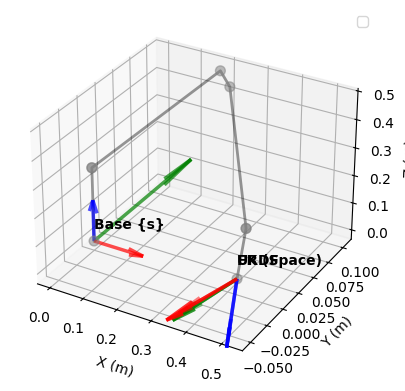

In [93]:

import numpy as np
from scipy.spatial.transform import Rotation
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# JOINT LIMITS 
JOINT_LIMITS = {
    'joint1': (-2*np.pi, 2*np.pi),      # ±360°
    'joint2': (-2.059, 2.0944),          # -118° to 120°
    'joint3': (-2*np.pi, 2*np.pi),      # ±360°
    'joint4': (-0.19198, 3.927),         # -11° to 225°
    'joint5': (-2*np.pi, 2*np.pi),      # ±360°
    'joint6': (-1.69297, 3.14159265),    # -97° to 180°
    'joint7': (-2*np.pi, 2*np.pi)       # ±360°
}

# ============================================================================
# MATRIX EXPONENTIAL AND FORWARD KINEMATICS
# ============================================================================

def skew_symmetric(v):
    return np.array([
        [0, -v[2], v[1]],
        [v[2], 0, -v[0]],
        [-v[1], v[0], 0]
    ])

def screw_to_se3(S):

    v = S[:3]
    omega = S[3:]
    se3_matrix = np.zeros((4, 4))
    se3_matrix[:3, :3] = skew_symmetric(omega)
    se3_matrix[:3, 3] = v
    return se3_matrix

def matrix_exponential_se3(se3_matrix, theta):

    omega_hat = se3_matrix[:3, :3]
    v = se3_matrix[:3, 3]
    
    # Extract omega vector from skew-symmetric matrix
    omega = np.array([omega_hat[2, 1], omega_hat[0, 2], omega_hat[1, 0]])
    omega_norm = np.linalg.norm(omega)
    
    if omega_norm < 1e-6:  # Pure translation (prismatic joint)
        T = np.eye(4)
        T[:3, 3] = v * theta
        return T
    
    # Rodrigues' formula for rotation
    omega_hat_normalized = omega_hat / omega_norm
    theta_scaled = theta * omega_norm
    
    I = np.eye(3)
    R = I + np.sin(theta_scaled) * omega_hat_normalized + \
        (1 - np.cos(theta_scaled)) * (omega_hat_normalized @ omega_hat_normalized)
    
    # Translation part
    omega_normalized = omega / omega_norm
    p = (I * theta_scaled + (1 - np.cos(theta_scaled)) * omega_hat_normalized + \
         (theta_scaled - np.sin(theta_scaled)) * (omega_hat_normalized @ omega_hat_normalized)) @ \
        (v / omega_norm)
    
    T = np.eye(4)
    T[:3, :3] = R
    T[:3, 3] = p
    return T

def FK_SpaceForm(theta, S_matrix, M):
    T = np.eye(4)
    n_joints = S_matrix.shape[1]
    
    for i in range(n_joints):
        S_i = S_matrix[:, i]
        se3_i = screw_to_se3(S_i)
        T = T @ matrix_exponential_se3(se3_i, theta[i])
    
    T_sb = T @ M
    return T_sb

def FK_BodyForm(theta, B_matrix, M):
    T = np.eye(4)
    n_joints = B_matrix.shape[1]
    
    for i in range(n_joints - 1, -1, -1):
        B_i = B_matrix[:, i]
        se3_i = screw_to_se3(B_i)
        T = T @ matrix_exponential_se3(se3_i, theta[i])
    
    T_sb = M @ T
    return T_sb

# ============================================================================
# URDF FORWARD KINEMATICS
# ============================================================================

def FK_URDF(theta):
    joints_data = [
        {'origin': [0, 0, 0.267], 'rpy': [0, 0, 0], 'axis': [0, 0, 1]},
        {'origin': [0, 0, 0], 'rpy': [-1.5708, 0, 0], 'axis': [0, 0, 1]},
        {'origin': [0, -0.293, 0], 'rpy': [1.5708, 0, 0], 'axis': [0, 0, 1]},
        {'origin': [0.0525, 0, 0], 'rpy': [1.5708, 0, 0], 'axis': [0, 0, 1]},
        {'origin': [0.0775, -0.3425, 0], 'rpy': [1.5708, 0, 0], 'axis': [0, 0, 1]},
        {'origin': [0, 0, 0], 'rpy': [1.5708, 0, 0], 'axis': [0, 0, 1]},
        {'origin': [0.076, 0.097, 0], 'rpy': [-1.5708, 0, 0], 'axis': [0, 0, 1]}
    ]
    
    T = np.eye(4)
    for i, joint in enumerate(joints_data):
        # Fixed transformation from parent to joint
        T_fixed = transformation_matrix(joint['origin'], joint['rpy'])
        
        # Revolute joint transformation
        axis = np.array(joint['axis'])
        angle = theta[i]
        R_joint = Rotation.from_rotvec(axis * angle).as_matrix()
        T_joint = np.eye(4)
        T_joint[:3, :3] = R_joint
        
        T = T @ T_fixed @ T_joint
    
    return T

# ============================================================================
# VISUALIZATION FUNCTIONS
# ============================================================================

def plot_transform(ax, T, label='', scale=0.1, alpha=1.0):
    origin = T[:3, 3]
    R = T[:3, :3]
    
    colors = ['r', 'g', 'b']
    labels = ['X', 'Y', 'Z']
    
    for i in range(3):
        axis = R[:, i]
        ax.quiver(origin[0], origin[1], origin[2],
                 axis[0], axis[1], axis[2],
                 color=colors[i], arrow_length_ratio=0.3,
                 linewidth=2.5, alpha=alpha, length=scale)
    
    if label:
        ax.text(origin[0], origin[1], origin[2] + 0.05, label,
               fontsize=10, fontweight='bold')

# ============================================================================
# TEST AND VERIFICATION
# ============================================================================

def generate_random_feasible_angles():
    theta = np.zeros(7)
    for i, (lower, upper) in enumerate(JOINT_LIMITS.values()):
        theta[i] = np.random.uniform(lower, upper)
    return theta

# Test multiple configurations
print("\n" + "="*80)
print("FORWARD KINEMATICS VERIFICATION")
print("="*80)

# Test 1: Zero configuration (home)
print("\nTest 1: Home Configuration (all joints at 0)")
print("-"*80)
theta_home = np.zeros(7)

T_space = FK_SpaceForm(theta_home, S_matrix, M)
T_urdf = FK_URDF(theta_home)

print("FK Space Form result:")
print(T_space)
print("\nURDF FK result:")
print(T_urdf)


# Test 2: Random feasible configuration
print("\n" + "="*80)
print("Test 2: Random Feasible Configuration")
print("-"*80)
theta_test = generate_random_feasible_angles()
print(f"Joint angles (degrees): {np.rad2deg(theta_test)}")

T_space = FK_SpaceForm(theta_test, S_matrix, M)
T_urdf = FK_URDF(theta_test)

print("\nFK Space Form result:")
print(T_space)
print("\nURDF FK result:")
print(T_urdf)


# ============================================================================
# VISUAL VERIFICATION
# ============================================================================

print("\n" + "="*80)
print("VISUAL VERIFICATION")
print("="*80)

fig = plt.figure(figsize=(16, 6))

# Configuration for visualization
theta_vis = np.array([np.pi/6, np.pi/4, -np.pi/6, np.pi/3, np.pi/4, -np.pi/6, np.pi/4])
print(f"\nVisualization configuration (degrees): {np.rad2deg(theta_vis)}")

# Plot 1: Comparison at test configuration
ax1 = fig.add_subplot(131, projection='3d')

# Compute transformations
T_space_vis = FK_SpaceForm(theta_vis, S_matrix, M)
T_urdf_vis = FK_URDF(theta_vis)

# Plot base frame
T_base = np.eye(4)
plot_transform(ax1, T_base, label='Base {s}', scale=0.15, alpha=0.7)

# Plot FK results
plot_transform(ax1, T_space_vis, label='FK (Space)', scale=0.12, alpha=0.8)
plot_transform(ax1, T_urdf_vis, label='URDF', scale=0.10, alpha=0.5)

# Plot robot skeleton from URDF
joints_data = [
    {'origin': [0, 0, 0.267], 'rpy': [0, 0, 0], 'axis': [0, 0, 1]},
    {'origin': [0, 0, 0], 'rpy': [-1.5708, 0, 0], 'axis': [0, 0, 1]},
    {'origin': [0, -0.293, 0], 'rpy': [1.5708, 0, 0], 'axis': [0, 0, 1]},
    {'origin': [0.0525, 0, 0], 'rpy': [1.5708, 0, 0], 'axis': [0, 0, 1]},
    {'origin': [0.0775, -0.3425, 0], 'rpy': [1.5708, 0, 0], 'axis': [0, 0, 1]},
    {'origin': [0, 0, 0], 'rpy': [1.5708, 0, 0], 'axis': [0, 0, 1]},
    {'origin': [0.076, 0.097, 0], 'rpy': [-1.5708, 0, 0], 'axis': [0, 0, 1]}
]

T = np.eye(4)
positions = [[0, 0, 0]]
for i, joint in enumerate(joints_data):
    T_fixed = transformation_matrix(joint['origin'], joint['rpy'])
    axis = np.array(joint['axis'])
    R_joint = Rotation.from_rotvec(axis * theta_vis[i]).as_matrix()
    T_joint = np.eye(4)
    T_joint[:3, :3] = R_joint
    T = T @ T_fixed @ T_joint
    positions.append(T[:3, 3].tolist())

positions = np.array(positions)
ax1.plot(positions[:, 0], positions[:, 1], positions[:, 2], 
        'k-', linewidth=2, alpha=0.4)
ax1.scatter(positions[:, 0], positions[:, 1], positions[:, 2], 
           c='gray', s=50, alpha=0.5)

ax1.set_xlabel('X (m)')
ax1.set_ylabel('Y (m)')
ax1.set_zlabel('Z (m)')
ax1.legend()


3. By considering the robot joint limits from the Specification file, roughly determine the robot reachable workspace (i.e., all the positions of the origin of the end-effector {b}) in Cartesian space R 3.Plot the workspace in y − x, z − y, and z − x planes.

xArm 7 REACHABLE WORKSPACE ANALYSIS

Joint Limits:
  joint1: [ -360.0°,   360.0°]
  joint2: [ -118.0°,   120.0°]
  joint3: [ -360.0°,   360.0°]
  joint4: [  -11.0°,   225.0°]
  joint5: [ -360.0°,   360.0°]
  joint6: [  -97.0°,   180.0°]
  joint7: [ -360.0°,   360.0°]
SAMPLING WORKSPACE: 50000 samples using random method
  Sampled 10000/50000 configurations...
  Sampled 20000/50000 configurations...
  Sampled 30000/50000 configurations...
  Sampled 40000/50000 configurations...
  Sampled 50000/50000 configurations...

✓ Sampling complete: 50000 valid positions

WORKSPACE STATISTICS

X-axis range: [-0.7666, 0.7641] m
Y-axis range: [-0.7647, 0.7661] m
Z-axis range: [-0.3610, 1.0359] m


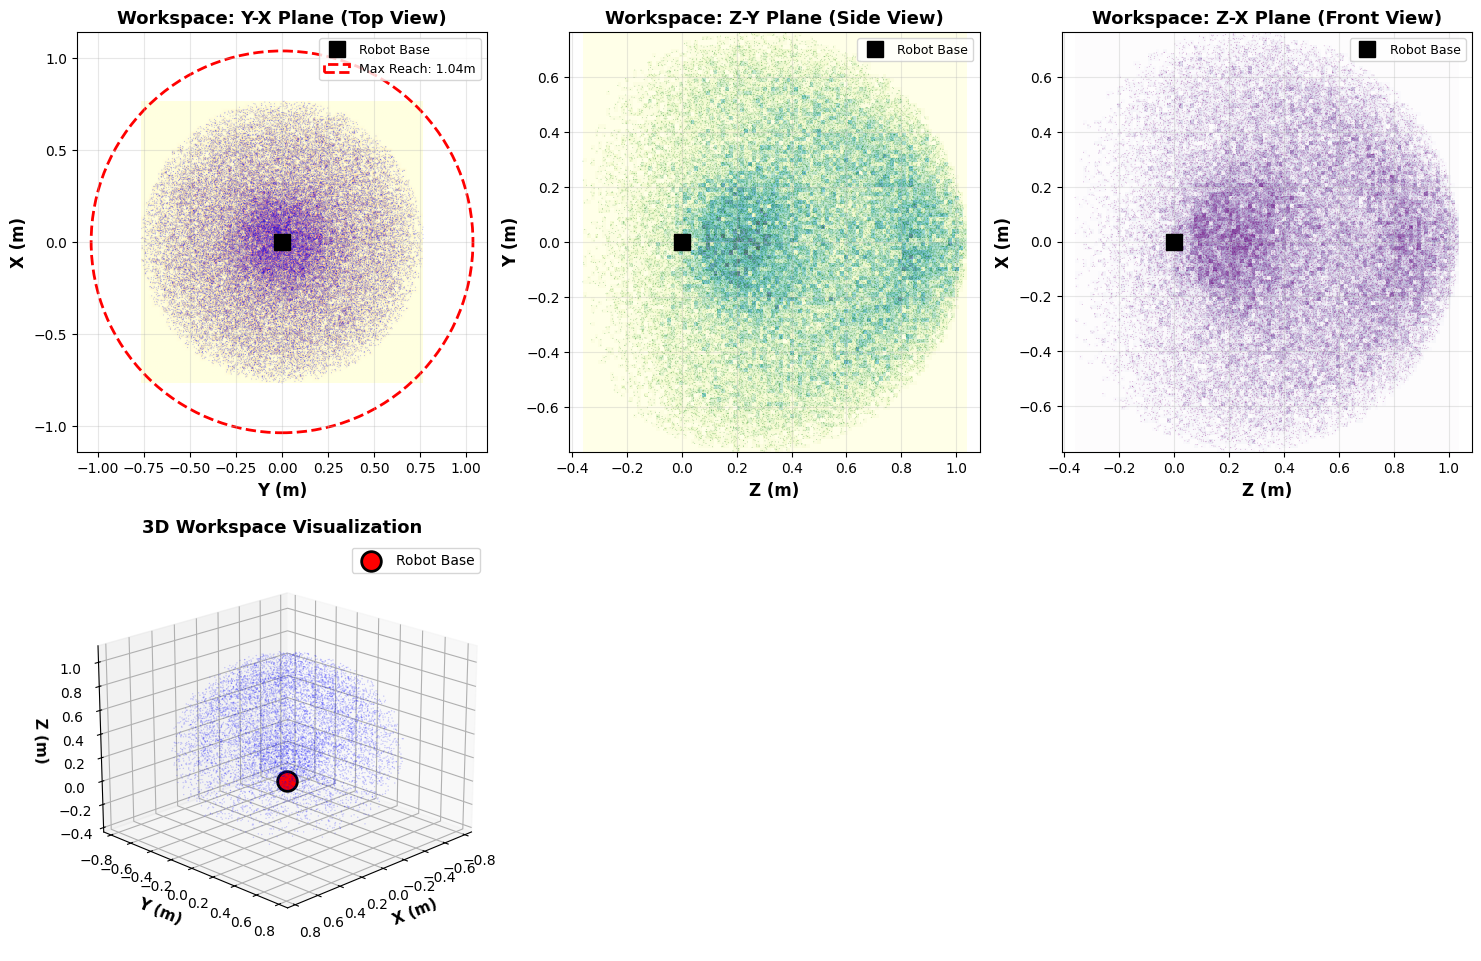

In [94]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from scipy.spatial.transform import Rotation
from mpl_toolkits.mplot3d import Axes3D

np.set_printoptions(precision=4, suppress=True)

print("xArm 7 REACHABLE WORKSPACE ANALYSIS")
print("\nJoint Limits:")
for joint, (lower, upper) in JOINT_LIMITS.items():
    print(f"  {joint}: [{np.rad2deg(lower):7.1f}°, {np.rad2deg(upper):7.1f}°]")


# ============================================================================
# WORKSPACE SAMPLING
# ============================================================================

def sample_workspace(n_samples=50000, method='random'):
    print(f"SAMPLING WORKSPACE: {n_samples} samples using {method} method")
    positions = []
    limits_array = np.array(list(JOINT_LIMITS.values()))
    
    if method == 'random':
        for i in range(n_samples):
            theta = np.random.uniform(limits_array[:, 0], limits_array[:, 1])
            T = FK_URDF(theta)
            positions.append(T[:3, 3])
            
            if (i + 1) % 10000 == 0:
                print(f"  Sampled {i+1}/{n_samples} configurations...")
    
    elif method == 'grid':
        n_per_joint = int(np.ceil(n_samples ** (1/7)))
        print(f"  Using {n_per_joint} samples per joint (total ~{n_per_joint**7})")
        # Create grid for each joint
        joint_grids = [np.linspace(lower, upper, n_per_joint) 
                      for lower, upper in limits_array]
        # Sample from grid (not full Cartesian product due to size)
        count = 0
        for _ in range(n_samples):
            theta = np.array([np.random.choice(grid) for grid in joint_grids])
            T = FK_URDF(theta)
            positions.append(T[:3, 3])
            count += 1
            if count % 10000 == 0:
                print(f"  Sampled {count}/{n_samples} configurations...")
    
    positions = np.array(positions)
    print(f"\n✓ Sampling complete: {len(positions)} valid positions")
    return positions

# Sample workspace
workspace_positions = sample_workspace(n_samples=50000, method='random')

# ============================================================================
# WORKSPACE ANALYSIS
# ============================================================================

print("\n" + "="*80)
print("WORKSPACE STATISTICS")
print("="*80)

x_coords = workspace_positions[:, 0]
y_coords = workspace_positions[:, 1]
z_coords = workspace_positions[:, 2]

print(f"\nX-axis range: [{x_coords.min():.4f}, {x_coords.max():.4f}] m")
print(f"Y-axis range: [{y_coords.min():.4f}, {y_coords.max():.4f}] m")
print(f"Z-axis range: [{z_coords.min():.4f}, {z_coords.max():.4f}] m")


# ============================================================================
# VISUALIZATION
# ============================================================================

fig = plt.figure(figsize=(18, 12))

# Common plot settings
point_size = 0.5
point_alpha = 0.3
density_alpha = 0.6

# ============================================================================
# Plot 1: Y-X Plane (Top View)
# ============================================================================
ax1 = fig.add_subplot(2, 3, 1)

# 2D histogram for density
hist_yx, xedges, yedges = np.histogram2d(y_coords, x_coords, bins=100)
extent_yx = [yedges[0], yedges[-1], xedges[0], xedges[-1]]
im1 = ax1.imshow(hist_yx.T, extent=extent_yx, origin='lower', 
                 cmap='YlOrRd', aspect='auto', alpha=density_alpha)
ax1.scatter(y_coords, x_coords, s=point_size, alpha=point_alpha, c='blue', edgecolors='none')

# Add robot base
ax1.plot(0, 0, 'ks', markersize=12, label='Robot Base', markerfacecolor='black')

# Add reference circles
max_reach = distances.max()
circle_outer = Circle((0, 0), max_reach, fill=False, edgecolor='red', 
                      linestyle='--', linewidth=2, label=f'Max Reach: {max_reach:.2f}m')
ax1.add_patch(circle_outer)

ax1.set_xlabel('Y (m)', fontsize=12, fontweight='bold')
ax1.set_ylabel('X (m)', fontsize=12, fontweight='bold')
ax1.set_title('Workspace: Y-X Plane (Top View)', fontsize=13, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.axis('equal')
ax1.legend(loc='upper right', fontsize=9)

# ============================================================================
# Plot 2: Z-Y Plane (Side View)
# ============================================================================
ax2 = fig.add_subplot(2, 3, 2)

hist_zy, yedges, zedges = np.histogram2d(z_coords, y_coords, bins=100)
extent_zy = [yedges[0], yedges[-1], zedges[0], zedges[-1]]
im2 = ax2.imshow(hist_zy.T, extent=extent_zy, origin='lower', 
                 cmap='YlGnBu', aspect='auto', alpha=density_alpha)
ax2.scatter(z_coords, y_coords, s=point_size, alpha=point_alpha, c='green', edgecolors='none')

# Add robot base
ax2.plot(0, 0, 'ks', markersize=12, label='Robot Base', markerfacecolor='black')

ax2.set_xlabel('Z (m)', fontsize=12, fontweight='bold')
ax2.set_ylabel('Y (m)', fontsize=12, fontweight='bold')
ax2.set_title('Workspace: Z-Y Plane (Side View)', fontsize=13, fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.axis('equal')
ax2.legend(loc='upper right', fontsize=9)

# ============================================================================
# Plot 3: Z-X Plane (Front View)
# ============================================================================
ax3 = fig.add_subplot(2, 3, 3)

hist_zx, xedges, zedges = np.histogram2d(z_coords, x_coords, bins=100)
extent_zx = [xedges[0], xedges[-1], zedges[0], zedges[-1]]
im3 = ax3.imshow(hist_zx.T, extent=extent_zx, origin='lower', 
                 cmap='Purples', aspect='auto', alpha=density_alpha)
ax3.scatter(z_coords, x_coords, s=point_size, alpha=point_alpha, c='purple', edgecolors='none')

# Add robot base
ax3.plot(0, 0, 'ks', markersize=12, label='Robot Base', markerfacecolor='black')

ax3.set_xlabel('Z (m)', fontsize=12, fontweight='bold')
ax3.set_ylabel('X (m)', fontsize=12, fontweight='bold')
ax3.set_title('Workspace: Z-X Plane (Front View)', fontsize=13, fontweight='bold')
ax3.grid(True, alpha=0.3)
ax3.axis('equal')
ax3.legend(loc='upper right', fontsize=9)

# ============================================================================
# Plot 4: 3D Workspace Visualization
# ============================================================================
ax4 = fig.add_subplot(2, 3, 4, projection='3d')

# Subsample for 3D plot (for performance)
subsample_idx = np.random.choice(len(workspace_positions), 
                                 min(10000, len(workspace_positions)), 
                                 replace=False)
ws_subsample = workspace_positions[subsample_idx]

ax4.scatter(ws_subsample[:, 0], ws_subsample[:, 1], ws_subsample[:, 2],
           s=1, alpha=0.2, c='blue', edgecolors='none')

# Plot robot base
ax4.scatter([0], [0], [0], c='red', s=200, marker='o', 
           edgecolors='black', linewidths=2, label='Robot Base')

ax4.set_xlabel('X (m)', fontsize=11, fontweight='bold')
ax4.set_ylabel('Y (m)', fontsize=11, fontweight='bold')
ax4.set_zlabel('Z (m)', fontsize=11, fontweight='bold')
ax4.set_title('3D Workspace Visualization', fontsize=13, fontweight='bold')
ax4.legend()
ax4.view_init(elev=20, azim=45)


Q4. Determine if the robot is kinematically redundant for performing a general task by its end-effector in Cartesian space R 3 . Moreover, determine as many (boundary and internal) singular configurations θ ∗ of the robot as possible, and verify them using the condition number or rank of body Jacobian Jb ∈ R 6×n or geometric Jacobian Jg ∈ R 6×n . Furthermore, plot the robot in some of those singular configurations. Note that the geometric Jacobian Jg is defined as  ωs p˙  = Jg(θ)θ˙ and you can compute it using Jg =  Jg,ω Jg,v =  I 0 −[p] I  Js where ωs ∈ R 3 is the angular velocity of the end-effector frame {b} expressed in {s}, p ∈ R 3 and p˙ ∈ R 3 are the position and linear velocity of the origin of the end-effector frame {b} expressed in {s}, respectively, I ∈ R 3×3 is an identity matrix, and [p] ∈ so(3). You can use the Jacobian functions J SpaceForm or J BodyForm you have written for HW#6

KINEMATIC REDUNDANCY ANALYSIS

Robot DOF: n = 7
Task space dimension (general): m = 6 (position + orientation)
Task space dimension (position only): m = 3

Redundancy Analysis:
  Robot IS KINEMATICALLY REDUNDANT for general tasks
    Degree of redundancy: 1
  Robot IS KINEMATICALLY REDUNDANT for position-only tasks
    Degree of redundancy: 4

### 1. BOUNDARY SINGULARITIES (Joint Limits) ###

BOUNDARY: J2 at lower limit
--------------------------------------------------------------------------------
Joint angles (deg): [   0.      -117.97201    0.         0.         0.         0.         0.     ]
Jacobian shape: (6, 7)
Rank: 6 (full rank = 6)
Condition number: 2.050910e+01
Singular values: [1.819038 1.79517  0.847963 0.255549 0.146103 0.088694]
Minimum singular value: 8.869418e-02
Manipulability: 9.169645e-03
✓ Non-singular configuration

BOUNDARY: J2 at upper limit
--------------------------------------------------------------------------------
Joint angles (deg): [  0.       120.0002

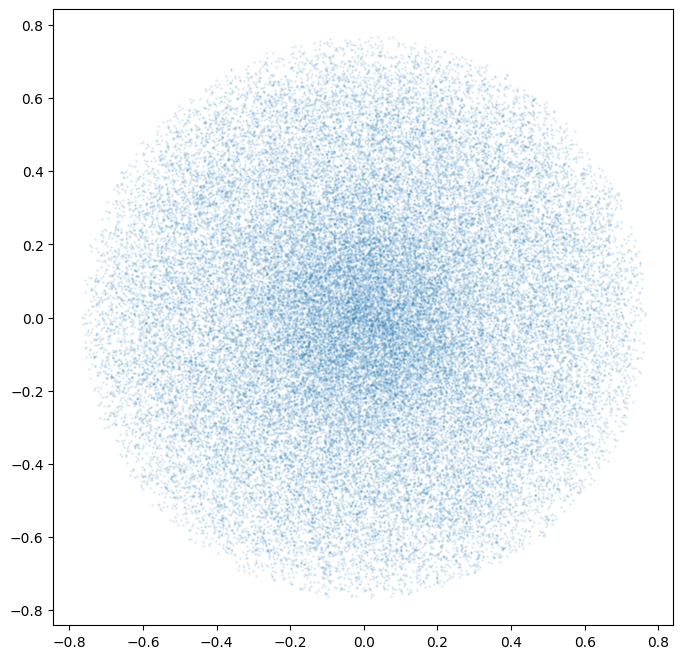

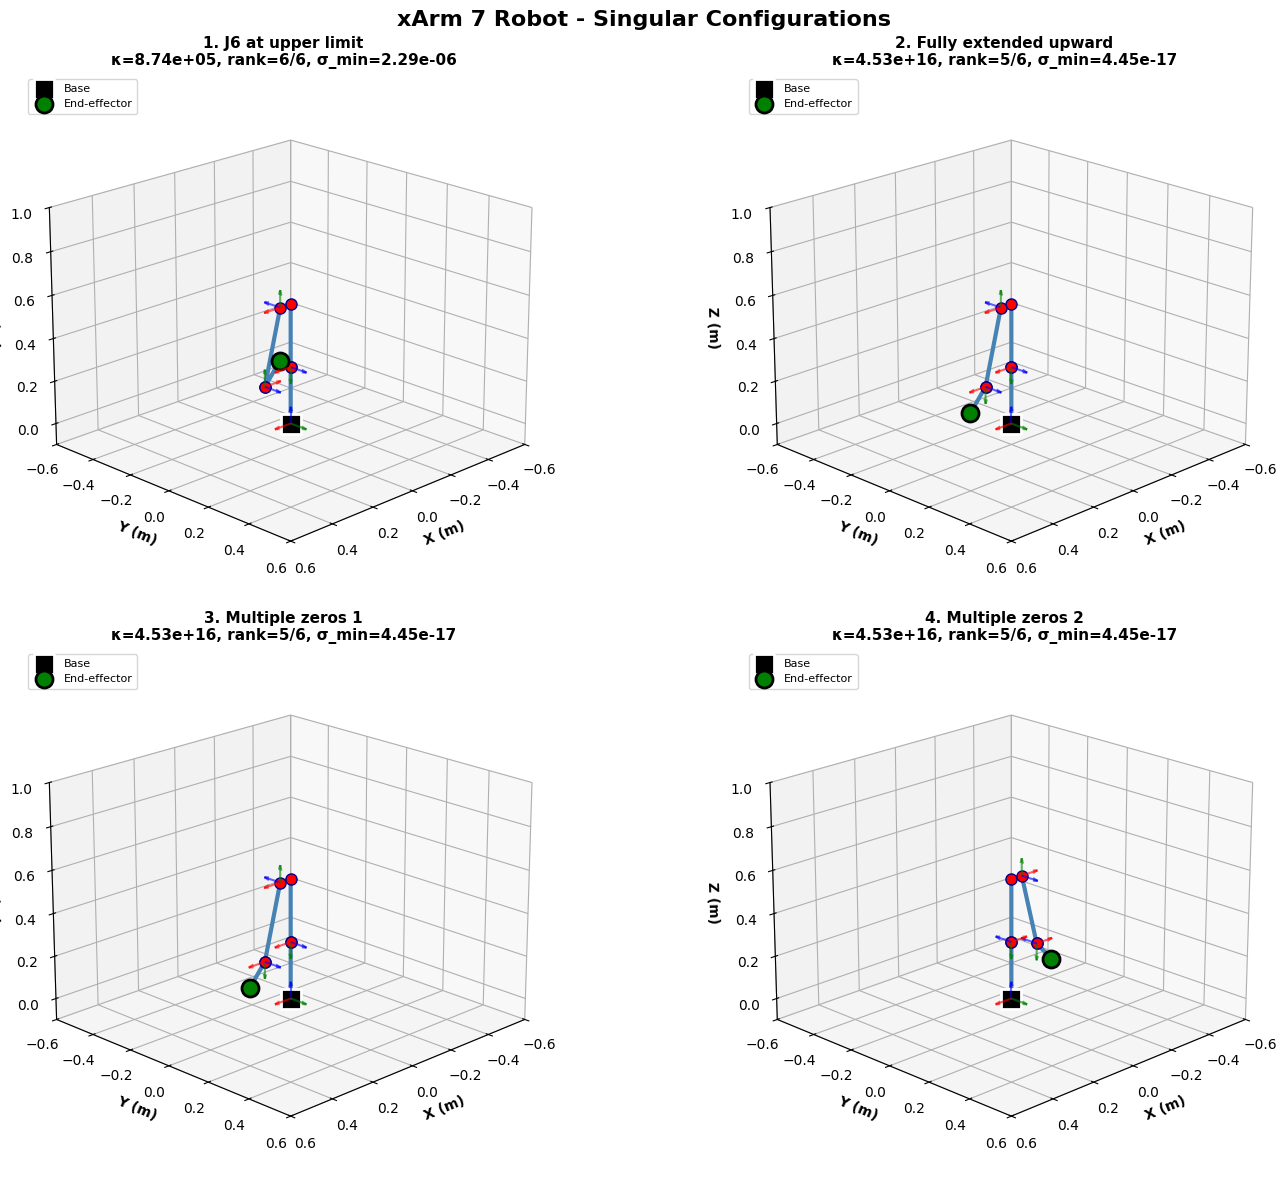


CREATING DETAILED VISUALIZATION WITH JACOBIAN ANALYSIS


AttributeError: Axes3D.set() got an unexpected keyword argument 'colspan'

<Figure size 2000x1400 with 0 Axes>

In [95]:

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial.transform import Rotation
from scipy.linalg import svd

np.set_printoptions(precision=6, suppress=True, linewidth=120)

# ============================================================================
# KINEMATIC REDUNDANCY ANALYSIS
# ============================================================================

print("KINEMATIC REDUNDANCY ANALYSIS")

n_joints = 7
m_task = 6
m_position = 3 

print(f"\nRobot DOF: n = {n_joints}")
print(f"Task space dimension (general): m = {m_task} (position + orientation)")
print(f"Task space dimension (position only): m = {m_position}")

print(f"\nRedundancy Analysis:")
if n_joints > m_task:
    print(f"  Robot IS KINEMATICALLY REDUNDANT for general tasks")
    print(f"    Degree of redundancy: {n_joints - m_task}")
elif n_joints == m_task:
    print(f"  Robot is NON-REDUNDANT for general tasks")
else:
    print(f"  Robot is UNDER-ACTUATED")

if n_joints > m_position:
    print(f"  Robot IS KINEMATICALLY REDUNDANT for position-only tasks")
    print(f"    Degree of redundancy: {n_joints - m_position}")

# ============================================================================
# FORWARD KINEMATICS AND SCREW AXES
# ============================================================================

def rpy_to_rotation_matrix(rpy):
    r = Rotation.from_euler('xyz', rpy)
    return r.as_matrix()

def transformation_matrix(origin, rpy):
    T = np.eye(4)
    T[:3, :3] = rpy_to_rotation_matrix(rpy)
    T[:3, 3] = origin
    return T

def compute_screw_parameters():
    """Compute S matrix and M from URDF."""
    joints_data = [
        {'origin': [0, 0, 0.267], 'rpy': [0, 0, 0], 'axis': [0, 0, 1]},
        {'origin': [0, 0, 0], 'rpy': [-1.5708, 0, 0], 'axis': [0, 0, 1]},
        {'origin': [0, -0.293, 0], 'rpy': [1.5708, 0, 0], 'axis': [0, 0, 1]},
        {'origin': [0.0525, 0, 0], 'rpy': [1.5708, 0, 0], 'axis': [0, 0, 1]},
        {'origin': [0.0775, -0.3425, 0], 'rpy': [1.5708, 0, 0], 'axis': [0, 0, 1]},
        {'origin': [0, 0, 0], 'rpy': [1.5708, 0, 0], 'axis': [0, 0, 1]},
        {'origin': [0.076, 0.097, 0], 'rpy': [-1.5708, 0, 0], 'axis': [0, 0, 1]}
    ]
    
    T_current = np.eye(4)
    space_screws = []
    
    for joint in joints_data:
        T_joint = transformation_matrix(joint['origin'], joint['rpy'])
        T_current = T_current @ T_joint
        
        R = T_current[:3, :3]
        omega_s = R @ np.array(joint['axis'])
        omega_s = omega_s / np.linalg.norm(omega_s)
        
        q_s = T_current[:3, 3]
        v_s = -np.cross(omega_s, q_s)
        S_i = np.concatenate([v_s, omega_s])
        space_screws.append(S_i)
    
    M = T_current.copy()
    return np.column_stack(space_screws), M

S_matrix, M = compute_screw_parameters()

# ============================================================================
# JACOBIAN COMPUTATION
# ============================================================================

def skew_symmetric(v):
    """Convert 3D vector to skew-symmetric matrix."""
    return np.array([
        [0, -v[2], v[1]],
        [v[2], 0, -v[0]],
        [-v[1], v[0], 0]
    ])

def adjoint_transformation(T):
    """Compute adjoint [Ad_T]."""
    R = T[:3, :3]
    p = T[:3, 3]
    Ad = np.zeros((6, 6))
    Ad[:3, :3] = R
    Ad[3:, 3:] = R
    Ad[:3, 3:] = skew_symmetric(p) @ R
    return Ad

def screw_to_se3(S):
    """Convert screw axis to se(3) matrix."""
    v = S[:3]
    omega = S[3:]
    se3_matrix = np.zeros((4, 4))
    se3_matrix[:3, :3] = skew_symmetric(omega)
    se3_matrix[:3, 3] = v
    return se3_matrix

def matrix_exponential_se3(se3_matrix, theta):
    """Compute e^([S]θ)."""
    omega_hat = se3_matrix[:3, :3]
    v = se3_matrix[:3, 3]
    
    omega = np.array([omega_hat[2, 1], omega_hat[0, 2], omega_hat[1, 0]])
    omega_norm = np.linalg.norm(omega)
    
    if omega_norm < 1e-6:
        T = np.eye(4)
        T[:3, 3] = v * theta
        return T
    
    omega_hat_normalized = omega_hat / omega_norm
    theta_scaled = theta * omega_norm
    
    I = np.eye(3)
    R = I + np.sin(theta_scaled) * omega_hat_normalized + \
        (1 - np.cos(theta_scaled)) * (omega_hat_normalized @ omega_hat_normalized)
    
    p = (I * theta_scaled + (1 - np.cos(theta_scaled)) * omega_hat_normalized + \
         (theta_scaled - np.sin(theta_scaled)) * (omega_hat_normalized @ omega_hat_normalized)) @ \
        (v / omega_norm)
    
    T = np.eye(4)
    T[:3, :3] = R
    T[:3, 3] = p
    return T

def FK_SpaceForm(theta, S_matrix, M):
    T = np.eye(4)
    for i in range(S_matrix.shape[1]):
        S_i = S_matrix[:, i]
        se3_i = screw_to_se3(S_i)
        T = T @ matrix_exponential_se3(se3_i, theta[i])
    return T @ M

def J_SpaceForm(theta, S_matrix):
    n = S_matrix.shape[1]
    Js = np.zeros((6, n))
    
    T = np.eye(4)
    for i in range(n):
        if i == 0:
            Js[:, i] = S_matrix[:, i]
        else:
            Ad_T = adjoint_transformation(T)
            Js[:, i] = Ad_T @ S_matrix[:, i]
        
        S_i = S_matrix[:, i]
        se3_i = screw_to_se3(S_i)
        T = T @ matrix_exponential_se3(se3_i, theta[i])
    
    return Js

def J_BodyForm(theta, S_matrix, M):

    Js = J_SpaceForm(theta, S_matrix)
    T = FK_SpaceForm(theta, S_matrix, M)
    Ad_T_inv = adjoint_transformation(np.linalg.inv(T))
    Jb = Ad_T_inv @ Js
    return Jb

def J_Geometric(theta, S_matrix, M):
    Js = J_SpaceForm(theta, S_matrix)
    T = FK_SpaceForm(theta, S_matrix, M)
    p = T[:3, 3]
    
    # Create transformation matrix
    transform = np.zeros((6, 6))
    transform[:3, :3] = np.eye(3)
    transform[3:, 3:] = np.eye(3)
    transform[3:, :3] = -skew_symmetric(p)
    
    Jg = transform @ Js
    return Jg

def analyze_jacobian(J, theta, config_name=""):
    print(f"\n{config_name}")
    print("-" * 80)
    
    # Compute SVD
    U, s, Vt = svd(J)
    
    # Condition number
    cond = np.linalg.cond(J)
    
    # Rank
    rank = np.linalg.matrix_rank(J, tol=1e-6)
    
    # Manipulability
    manipulability = np.sqrt(np.linalg.det(J @ J.T))
    
    print(f"Joint angles (deg): {np.rad2deg(theta)}")
    print(f"Jacobian shape: {J.shape}")
    print(f"Rank: {rank} (full rank = {min(J.shape)})")
    print(f"Condition number: {cond:.6e}")
    print(f"Singular values: {s}")
    print(f"Minimum singular value: {s[-1]:.6e}")
    print(f"Manipulability: {manipulability:.6e}")
    
    is_singular = (rank < min(J.shape)) or (s[-1] < 1e-3) or (cond > 1e6)
    
    if is_singular:
        print("SINGULAR CONFIGURATION DETECTED")
        if rank < min(J.shape):
            print(f"   → Rank deficient: rank = {rank} < {min(J.shape)}")
        if s[-1] < 1e-3:
            print(f"   → Small singular value: σ_min = {s[-1]:.2e}")
        if cond > 1e6:
            print(f"   → High condition number: κ = {cond:.2e}")
    else:
        print("✓ Non-singular configuration")

    return {
        'rank': rank,
        'condition_number': cond,
        'singular_values': s,
        'manipulability': manipulability,
        'is_singular': is_singular
    }

# ============================================================================
# SINGULAR CONFIGURATION SEARCH
# ============================================================================

singular_configs = []

# ============================================================================
# 1. BOUNDARY SINGULARITIES - Joint Limits
# ============================================================================

print("\n### 1. BOUNDARY SINGULARITIES (Joint Limits) ###")

JOINT_LIMITS = np.array([
    (-2*np.pi, 2*np.pi),
    (np.deg2rad(-118), np.deg2rad(120)),
    (-2*np.pi, 2*np.pi),
    (np.deg2rad(-11), np.deg2rad(225)),
    (-2*np.pi, 2*np.pi),
    (np.deg2rad(-97), np.deg2rad(180)),
    (-2*np.pi, 2*np.pi)
])

# Test configurations at joint limits
boundary_configs = [
    ("J2 at lower limit", np.array([0, -2.059, 0, 0, 0, 0, 0])),
    ("J2 at upper limit", np.array([0, 2.0944, 0, 0, 0, 0, 0])),
    ("J4 at lower limit", np.array([0, 0, 0, -0.19198, 0, 0, 0])),
    ("J4 at upper limit", np.array([0, 0, 0, 3.927, 0, 0, 0])),
    ("J6 at lower limit", np.array([0, 0, 0, 0, 0, -1.69297, 0])),
    ("J6 at upper limit", np.array([0, 0, 0, 0, 0, 3.14159, 0])),
]

for name, theta in boundary_configs:
    Jb = J_BodyForm(theta, S_matrix, M)
    result = analyze_jacobian(Jb, theta, f"BOUNDARY: {name}")
    if result['is_singular']:
        singular_configs.append(('boundary', name, theta.copy(), result))

# ============================================================================
# 2. INTERNAL SINGULARITIES - Special Configurations
# ============================================================================

print("\n### 2. INTERNAL SINGULARITIES ###")

internal_configs = [
    # Fully extended (all joints aligned)
    ("Fully extended upward", np.array([0, 0, 0, 0, 0, 0, 0])),
    
    # Fully folded
    ("Folded configuration 1", np.array([0, np.pi/2, 0, np.pi/2, 0, 0, 0])),
    
    # Wrist singularities (J5 = 0 aligns wrist axes)
    ("Wrist singularity 1", np.array([0, np.pi/4, 0, np.pi/4, 0, 0, 0])),
    
    # Shoulder singularity (J2 = 0, arm extended horizontally)
    ("Shoulder singularity", np.array([0, 0, 0, np.pi/2, 0, 0, 0])),
    
    # Elbow singularity (J4 approaches limits)
    ("Elbow singularity 1", np.array([0, np.pi/4, 0, 0.1, 0, 0, 0])),
    ("Elbow singularity 2", np.array([0, np.pi/4, 0, 3.8, 0, 0, 0])),
    
    # Wrist center aligned configurations
    ("Wrist aligned 1", np.array([0, np.pi/6, 0, np.pi/3, 0, np.pi/6, 0])),
    
    # Multiple joints at zero
    ("Multiple zeros 1", np.array([0, 0, 0, 0, 0, 0, 0])),
    ("Multiple zeros 2", np.array([np.pi, 0, 0, 0, 0, 0, 0])),
]

for name, theta in internal_configs:
    Jb = J_BodyForm(theta, S_matrix, M)
    result = analyze_jacobian(Jb, theta, f"INTERNAL: {name}")
    if result['is_singular']:
        singular_configs.append(('internal', name, theta.copy(), result))

# ============================================================================
# SUMMARY OF SINGULAR CONFIGURATIONS
# ============================================================================

print("SUMMARY OF SINGULAR CONFIGURATIONS FOUND")

print(f"\nTotal singular configurations found: {len(singular_configs)}")

for i, (config_type, name, theta, result) in enumerate(singular_configs[:10]):  # Show first 10
    print(f"\n{i+1}. {name} ({config_type})")
    print(f"   θ (deg) = {np.rad2deg(theta).round(2)}")
    print(f"   Condition number: {result['condition_number']:.2e}")
    print(f"   Rank: {result['rank']}/6")
    print(f"   Min singular value: {result['singular_values'][-1]:.2e}")

if len(singular_configs) > 10:
    print(f"\n... and {len(singular_configs) - 10} more configurations")

plt.figure(figsize=(8, 8))
plt.scatter(workspace_positions[:, 0],
            workspace_positions[:, 1],
            s=1, alpha=0.1, label='Workspace')


# ============================================================================
# ROBOT VISUALIZATION FUNCTIONS
# ============================================================================

def FK_URDF_all_links(theta):
    """Compute FK for all links to visualize robot."""
    joints_data = [
        {'origin': [0, 0, 0.267], 'rpy': [0, 0, 0], 'axis': [0, 0, 1]},
        {'origin': [0, 0, 0], 'rpy': [-1.5708, 0, 0], 'axis': [0, 0, 1]},
        {'origin': [0, -0.293, 0], 'rpy': [1.5708, 0, 0], 'axis': [0, 0, 1]},
        {'origin': [0.0525, 0, 0], 'rpy': [1.5708, 0, 0], 'axis': [0, 0, 1]},
        {'origin': [0.0775, -0.3425, 0], 'rpy': [1.5708, 0, 0], 'axis': [0, 0, 1]},
        {'origin': [0, 0, 0], 'rpy': [1.5708, 0, 0], 'axis': [0, 0, 1]},
        {'origin': [0.076, 0.097, 0], 'rpy': [-1.5708, 0, 0], 'axis': [0, 0, 1]}
    ]
    
    T = np.eye(4)
    transforms = [T.copy()]
    positions = [[0, 0, 0]]
    
    for i, joint in enumerate(joints_data):
        T_fixed = transformation_matrix(joint['origin'], joint['rpy'])
        axis = np.array(joint['axis'])
        R_joint = Rotation.from_rotvec(axis * theta[i]).as_matrix()
        T_joint = np.eye(4)
        T_joint[:3, :3] = R_joint
        
        T = T @ T_fixed @ T_joint
        transforms.append(T.copy())
        positions.append(T[:3, 3].tolist())
    
    return transforms, np.array(positions)

def plot_robot(ax, theta, title="", show_frames=True):
    """Plot robot configuration in 3D."""
    transforms, positions = FK_URDF_all_links(theta)
    
    # Plot links
    ax.plot(positions[:, 0], positions[:, 1], positions[:, 2],
           'o-', markersize=8, color='steelblue', 
           markerfacecolor='red', markeredgecolor='darkblue', linewidth=3)
    
    # Plot base
    ax.scatter([0], [0], [0], c='black', s=200, marker='s', 
              edgecolors='white', linewidths=2, zorder=10, label='Base')
    
    # Plot end-effector
    ee_pos = positions[-1]
    ax.scatter([ee_pos[0]], [ee_pos[1]], [ee_pos[2]], 
              c='green', s=150, marker='o', edgecolors='black', 
              linewidths=2, label='End-effector')
    
    # Plot coordinate frames at joints
    if show_frames:
        for i, T in enumerate(transforms[::2]):  # Every other joint for clarity
            origin = T[:3, 3]
            R = T[:3, :3]
            scale = 0.08
            
            colors = ['r', 'g', 'b']
            for j in range(3):
                axis = R[:, j] * scale
                ax.quiver(origin[0], origin[1], origin[2],
                         axis[0], axis[1], axis[2],
                         color=colors[j], arrow_length_ratio=0.3,
                         linewidth=1.5, alpha=0.6)
    
    ax.set_xlabel('X (m)', fontsize=10, fontweight='bold')
    ax.set_ylabel('Y (m)', fontsize=10, fontweight='bold')
    ax.set_zlabel('Z (m)', fontsize=10, fontweight='bold')
    ax.set_title(title, fontsize=11, fontweight='bold')
    
    # Set equal aspect ratio
    max_range = 0.6
    ax.set_xlim([-max_range, max_range])
    ax.set_ylim([-max_range, max_range])
    ax.set_zlim([-0.1, 1.0])
    ax.grid(True, alpha=0.3)
    ax.legend(loc='upper left', fontsize=8)
    
    return ax


# ============================================================================
# VISUALIZE ONLY THE 4 FOUND SINGULAR CONFIGURATIONS
# ============================================================================

print("\n" + "="*80)
print("VISUALIZING THE 4 SINGULAR CONFIGURATIONS")
print("="*80)

if len(singular_configs) == 0:
    print("No singular configurations found to visualize.")
else:
    # Create figure with 2x2 grid for 4 configurations
    fig = plt.figure(figsize=(16, 12))
    
    for idx, (config_type, name, theta, result) in enumerate(singular_configs):
        ax = fig.add_subplot(2, 2, idx + 1, projection='3d')
        
        # Create title with key metrics
        title = f"{idx+1}. {name}\n"
        title += f"κ={result['condition_number']:.2e}, "
        title += f"rank={result['rank']}/6, "
        title += f"σ_min={result['singular_values'][-1]:.2e}"
        
        plot_robot(ax, theta, title, show_frames=True)
        
        # Set viewing angle for better visualization
        ax.view_init(elev=20, azim=45)
        
        print(f"Plotted {idx+1}: {name}")
    
    plt.suptitle('xArm 7 Robot - Singular Configurations', 
                fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.savefig('xarm7_singular_configurations.png', dpi=150, bbox_inches='tight')
    print(f"\n✓ Saved visualization to 'xarm7_singular_configurations.png'")
    plt.show()

# ============================================================================
# DETAILED VISUALIZATION WITH JACOBIAN INFO (2x2 LAYOUT)
# ============================================================================

print("\n" + "="*80)
print("CREATING DETAILED VISUALIZATION WITH JACOBIAN ANALYSIS")
print("="*80)

fig2 = plt.figure(figsize=(20, 14))

for idx, (config_type, name, theta, result) in enumerate(singular_configs):
    # Robot plot (top half of each quadrant)
    ax_robot = fig2.add_subplot(4, 4, idx*4 + 1, projection='3d', colspan=2)
    plot_robot(ax_robot, theta, f"{idx+1}. {name}", show_frames=True)
    ax_robot.view_init(elev=20, azim=45)
    
    # Jacobian info (bottom half of each quadrant)
    ax_info = fig2.add_subplot(4, 4, idx*4 + 3, colspan=2)
    ax_info.axis('off')
    
    # Create detailed info text
    info_text = f"""
Configuration {idx+1}: {name} ({config_type})
{'='*60}

Joint Angles (degrees):
  {np.array2string(np.rad2deg(theta), precision=1, separator=', ')}

Jacobian Properties:
  • Rank: {result['rank']}/6  {'← RANK DEFICIENT!' if result['rank'] < 6 else ''}
  • Condition Number: {result['condition_number']:.6e}  {'← SINGULAR!' if result['condition_number'] > 1e6 else ''}
  • Manipulability: {result['manipulability']:.6e}

Singular Values:
  σ₁ = {result['singular_values'][0]:.6e}
  σ₂ = {result['singular_values'][1]:.6e}
  σ₃ = {result['singular_values'][2]:.6e}
  σ₄ = {result['singular_values'][3]:.6e}
  σ₅ = {result['singular_values'][4]:.6e}
  σ₆ = {result['singular_values'][5]:.6e}  {'← NEAR ZERO!' if result['singular_values'][5] < 1e-3 else ''}

Singularity Verification:
"""
    
    reasons = []
    if result['rank'] < 6:
        reasons.append(f"✓ Rank deficient: rank = {result['rank']} < 6")
    if result['singular_values'][-1] < 1e-3:
        reasons.append(f"✓ Minimum singular value: σ_min = {result['singular_values'][-1]:.2e} < 0.001")
    if result['condition_number'] > 1e6:
        reasons.append(f"✓ High condition number: κ = {result['condition_number']:.2e} > 10⁶")
    
    for reason in reasons:
        info_text += f"  {reason}\n"
    
    info_text += "\n⚠️  SINGULAR CONFIGURATION CONFIRMED"
    
    ax_info.text(0.05, 0.95, info_text, fontsize=9, family='monospace',
                verticalalignment='top', fontweight='normal',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))

plt.suptitle('xArm 7 Singular Configurations - Detailed Analysis', 
            fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('xarm7_singular_detailed.png', dpi=150, bbox_inches='tight')
print(f"✓ Saved detailed visualization to 'xarm7_singular_detailed.png'")
plt.show()

# ============================================================================
# SINGULAR VALUE BAR CHARTS (2x2 LAYOUT)
# ============================================================================

print("\n" + "="*80)
print("CREATING SINGULAR VALUE ANALYSIS PLOTS")
print("="*80)

fig3, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for idx, (config_type, name, theta, result) in enumerate(singular_configs):
    ax = axes[idx]
    s_vals = result['singular_values']
    
    # Create bar chart
    bars = ax.bar(range(1, 7), s_vals, color='steelblue', 
                  edgecolor='black', linewidth=1.5)
    
    # Color small singular values red
    for i, val in enumerate(s_vals):
        if val < 1e-3:
            bars[i].set_color('red')
        elif val < 0.1:
            bars[i].set_color('orange')
    
    # Add threshold line
    ax.axhline(y=1e-3, color='red', linestyle='--', linewidth=2, 
              alpha=0.7, label='Singularity threshold (10⁻³)')
    
    ax.set_yscale('log')
    ax.set_xlabel('Singular Value Index', fontsize=11, fontweight='bold')
    ax.set_ylabel('Magnitude (log scale)', fontsize=11, fontweight='bold')
    ax.set_title(f'{idx+1}. {name}\nκ = {result["condition_number"]:.2e}, rank = {result["rank"]}', 
                fontsize=11, fontweight='bold')
    ax.grid(True, alpha=0.3, axis='y')
    ax.legend(fontsize=9)
    ax.set_ylim([1e-18, 10])
    ax.set_xticks(range(1, 7))

plt.suptitle('Singular Value Analysis of xArm 7 Singular Configurations', 
            fontsize=15, fontweight='bold')
plt.tight_layout()
plt.savefig('xarm7_singular_values.png', dpi=150, bbox_inches='tight')
print(f"✓ Saved singular value analysis to 'xarm7_singular_values.png'")
plt.show()

print("="*80)